In [155]:
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm  
import pickle
import os
import gzip

In [192]:
def load_fashion_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    #Load MNIST data from `path`
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels
# 调用函数加载数据
X_train, train_labels = load_fashion_mnist('/Users/fuchenxu/Desktop/computer vision/第一次作业/作业完整的/fashion', kind='train')
X_test, test_labels = load_fashion_mnist('/Users/fuchenxu/Desktop/computer vision/第一次作业/作业完整的/fashion', kind='t10k')
#X_test, test_labels = load_fashion_mnist('/Users/fuchenxu/Desktop/computer vision/第一次作业/作业完整的/fashion', 't10k')
y_train = train_labels
y_test = test_labels
y_train = one_hot(y_train.T,10)
y_test = one_hot(y_test.T,10)

In [193]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [89]:
def initialize_parameters(input_dim, hidden_dim, output_dim):
    np.random.seed(1)  # 确保结果的可复现性
    model = {
        'W1': np.random.randn(input_dim, hidden_dim) * 0.01,
        'b1': np.zeros((1, hidden_dim)),
        'W2': np.random.randn(hidden_dim, output_dim) * 0.01,
        'b2': np.zeros((1, output_dim))
    }
    return model


def save_model(model, filename):
    """
    将模型参数保存到文件中。

    Args:
        model (dict): 包含模型参数的字典。
        filename (str): 要保存文件的路径。
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename):
    """
    从文件中加载模型参数。

    Args:
        filename (str): 包含模型参数的文件路径。

    Returns:
        dict: 包含模型参数的字典。
    """
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model


In [62]:
def relu(Z):
    """ReLU激活函数"""
    return np.maximum(0, Z)

def softmax(Z):
    """Softmax激活函数"""
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=1, keepdims=True)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu_derivative(Z):
    """
    计算ReLU函数的导数。

    Args:
        Z (np.ndarray): ReLU函数的输入。

    Returns:
        np.ndarray: ReLU函数的导数。
    """
    return Z > 0

def softmax_derivative(Z):
    """
    Softmax函数本身是输出层的激活函数，其导数会与交叉熵损失结合来简化表达。

    Args:
        Z (np.ndarray): Softmax函数的输入。

    Returns:
        np.ndarray: 对交叉熵的梯度。
    """
    return Z  # 这里返回Z，因为在交叉熵的组合中，实际的导数计算已经简化



def forward_propagation(X, model, activation='relu'):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    Z1 = np.dot(X, W1) + b1
    if activation == 'relu':
        A1 = np.maximum(0, Z1)
    else:  # 默认为sigmoid
        A1 = 1 / (1 + np.exp(-Z1))
    Z2 = np.dot(A1, W2) + b2
    A2 = 1 / (1 + np.exp(-Z2))  # 输出层通常使用sigmoid激活函数，适用于多类分类
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2)
    return A2, cache


def backward_pass(X, Y, Y_hat,cache, params, beta, activation='relu'):
    grads = {}
    m = X.shape[0]
    # 解包缓存中的值
    Z1, A1, W1, b1, Z2, A2, W2, b2 = cache

    # 输出层梯度（假设输出层使用了softmax和交叉熵损失组合）
    dZ2 = A2 - Y
    dW2 = np.dot(A1.T, dZ2) / m + beta * W2
    db2 = np.sum(dZ2, axis=0) / m

    # 隐藏层梯度
    dA1 = np.dot(dZ2, W2.T)
    if activation == 'relu':
        dZ1 = dA1 * (Z1 > 0)  # ReLU激活函数的导数
    else:
        dZ1 = dA1 * A1 * (1 - A1)  # Sigmoid激活函数的导数

    dW1 = np.dot(X.T, dZ1) / m + beta * W1
    db1 = np.sum(dZ1, axis=0) / m

    grads['W1'] = dW1
    grads['b1'] = db1
    grads['W2'] = dW2
    grads['b2'] = db2

    return grads



def compute_loss(y_true, y_pred, params, beta):
    """
    计算包含L2正则化的交叉熵损失。

    Args:
        y_true (np.ndarray): 真实的标签，one-hot编码形式。
        y_pred (np.ndarray): 模型预测的输出概率，通过softmax计算得到。
        params (dict): 包含模型参数（权重和偏置）的字典。
        beta (float): L2正则化系数。

    Returns:
        float: 总损失值，包括交叉熵损失和正则化损失。
    """
    # 计算交叉熵损失
    cross_entropy_loss = np.mean(-np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    # 计算权重的L2正则化损失
    l2_loss = beta / 2 * sum(np.sum(np.square(weights)) for weights in [params['W1'], params['W2']])

    # 总损失为交叉熵损失与L2正则化损失之和
    total_loss = cross_entropy_loss + l2_loss
    return total_loss

def update_model(model, grads, learning_rate):
    """
    更新模型参数以进行梯度下降。

    Args:
        model (dict): 包含模型权重和偏置的字典。
        grads (dict): 包含梯度的字典，与模型字典结构相对应。
        learning_rate (float): 学习率。

    Returns:
        dict: 更新后的模型参数。
    """
    # 对每个参数进行更新
    for key in model.keys():
        model[key] -= learning_rate * grads[key]
    return model

def compute_accuracy(y_hat, y_true):
    """
    计算预测准确率。

    Args:
        y_hat (np.ndarray): 模型的预测输出，概率形式。
        y_true (np.ndarray): 真实的标签，one-hot编码形式。

    Returns:
        float: 预测的准确率。
    """
    # 计算预测的类别与真实类别是否相等，然后计算平均值
    predictions = np.argmax(y_hat, axis=1)
    labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy

def one_hot(labels, num_classes):
    """
    将标签数组转换为one-hot编码形式。

    Args:
        labels (np.ndarray): 标签数组。
        num_classes (int): 类别的总数。

    Returns:
        np.ndarray: one-hot编码的标签数组。
    """
    # 创建一个形状为(labels.size, num_classes)的零矩阵
    one_hot_labels = np.zeros((labels.size, num_classes))
    # 根据labels数组设置相应的索引为1
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

def evaluate_model(model, X, Y, beta, activation='relu'):
    """
    评估给定数据集上的模型性能。

    Args:
        model (dict): 包含模型参数的字典。
        X (np.ndarray): 数据集的特征。
        Y (np.ndarray): 数据集的标签，one-hot编码形式。
        beta (float): L2正则化系数。
        activation (str): 使用的激活函数类型，如'relu'或'sigmoid'。

    Returns:
        tuple: 返回计算得到的损失和准确率。
    """
    # 进行前向传播
    Y_hat, _ = forward_propagation(X, model, activation)

    # 计算损失
    loss = compute_loss(Y, Y_hat, model, beta)

    # 计算准确率
    accuracy = compute_accuracy(Y_hat, Y)

    return loss, accuracy


In [19]:
class config:
    input_dim = 784
    hidden_dim = 512
    output_dim = 10
    learning_rate = 0.001
    decay_rate = 0.95
    beta = 0.001
    batch_size = 32
    num_epochs = 50
    # relu or sigmoid
    activation = 'sigmoid' 

In [69]:
def train_model(model, X_train, y_train, X_val, y_val, learning_rate, decay_rate, beta, num_epochs, batch_size, activation='relu'):
    """
    训练神经网络模型。

    Args:
        model (dict): 包含模型参数的字典。
        X_train (np.ndarray): 训练数据。
        y_train (np.ndarray): 训练数据的标签，one-hot编码形式。
        X_val (np.ndarray): 验证数据。
        y_val (np.ndarray): 验证数据的标签，one-hot编码形式。
        learning_rate (float): 初始学习率。
        decay_rate (float): 学习率衰减率。
        beta (float): L2正则化系数。
        num_epochs (int): 训练的总轮数。
        batch_size (int): 每个批次的样本数。
        activation (str): 使用的激活函数类型。

    Returns:
        tuple: 包含最终模型，最佳模型，训练和验证的损失及准确率历史。
    """
    num_train = X_train.shape[0]
    num_batches = num_train // batch_size

    history_train_losses = []
    history_train_accuracies = []
    history_val_losses = []
    history_val_accuracies = []
    best_val_accuracy = 0.0
    best_model = model

    for epoch in range(num_epochs):
        # 打乱数据顺序
        random_indices = np.random.permutation(num_train)
        X_train_shuffled = X_train[random_indices]
        y_train_shuffled = y_train[random_indices]

        # 迭代每个批次
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            # 前向传播
            y_hat, cache = forward_propagation(X_batch, model, activation)
            # 计算损失和梯度
            loss = compute_loss(y_batch, y_hat, model, beta)
            accuracy = compute_accuracy(y_hat, y_batch)
            grads = backward_pass(X_batch, y_batch, y_hat, cache, model, beta, activation)
            # 更新模型
            model = update_model(model, grads, learning_rate)

        # 在整个训练集和验证集上计算性能
        train_loss, train_accuracy = evaluate_model(model, X_train, y_train, beta, activation)
        val_loss, val_accuracy = evaluate_model(model, X_val, y_val, beta, activation)
        
        # 更新最佳模型
        best_val_accuracy = 0
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.copy()

        # 存储历史数据
        history_train_losses.append(train_loss)
        history_train_accuracies.append(train_accuracy)
        history_val_losses.append(val_loss)
        history_val_accuracies.append(val_accuracy)
        
        # 学习率衰减
        learning_rate *= decay_rate

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}')

    return model, best_model, history_train_losses, history_train_accuracies, history_val_losses, history_val_accuracies


In [199]:
input_dim = config.input_dim
hidden_dim = config.hidden_dim
output_dim = config.output_dim
learning_rate = config.learning_rate
decay_rate = config.decay_rate
beta = config.beta
batch_size = config.batch_size
num_epochs = config.num_epochs
activation = config.activation

model = initialize_parameters(784, 512, 10)
model, best_model, history_train_losses, history_train_accuracies, history_val_losses, history_val_accuracies = train_model(
    model, X_train, y_train, X_val, y_val, learning_rate, decay_rate, beta, num_epochs, batch_size, activation
)

Epoch 1/50: Train Loss = 0.8366, Train Accuracy = 0.7816, Val Loss = 0.8469, Val Accuracy = 0.7753
Epoch 2/50: Train Loss = 0.6447, Train Accuracy = 0.8178, Val Loss = 0.6524, Val Accuracy = 0.8142
Epoch 3/50: Train Loss = 0.5720, Train Accuracy = 0.8344, Val Loss = 0.5771, Val Accuracy = 0.8292
Epoch 4/50: Train Loss = 0.5129, Train Accuracy = 0.8442, Val Loss = 0.5152, Val Accuracy = 0.8415
Epoch 5/50: Train Loss = 0.4890, Train Accuracy = 0.8505, Val Loss = 0.4906, Val Accuracy = 0.8490
Epoch 6/50: Train Loss = 0.4766, Train Accuracy = 0.8550, Val Loss = 0.4793, Val Accuracy = 0.8500
Epoch 7/50: Train Loss = 0.4644, Train Accuracy = 0.8591, Val Loss = 0.4660, Val Accuracy = 0.8568
Epoch 8/50: Train Loss = 0.4567, Train Accuracy = 0.8617, Val Loss = 0.4587, Val Accuracy = 0.8593
Epoch 9/50: Train Loss = 0.4397, Train Accuracy = 0.8653, Val Loss = 0.4385, Val Accuracy = 0.8642
Epoch 10/50: Train Loss = 0.4388, Train Accuracy = 0.8670, Val Loss = 0.4399, Val Accuracy = 0.8625
Epoch 11/

In [200]:
save_model(model, 'trained_model.pkl')  # 指定保存的文件名

Model saved to trained_model.pkl


In [201]:
model = load_model('trained_model.pkl')

test_loss, test_accuracy = evaluate_model(model, X_test, y_test, beta, activation)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4%}")


Model loaded from trained_model.pkl
Test Loss: 0.4319, Test Accuracy: 86.8800%


In [137]:
import os

# 创建保存图像的目录，如果不存在的话
output_dir = "output/relu"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir = "output/sigmoid"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


Model loaded from trained_model.pkl


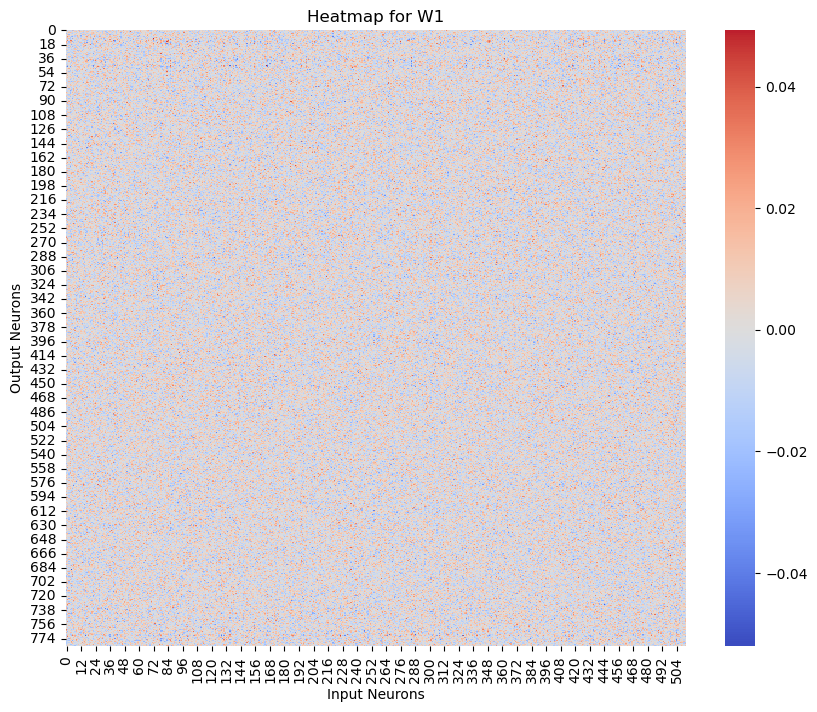

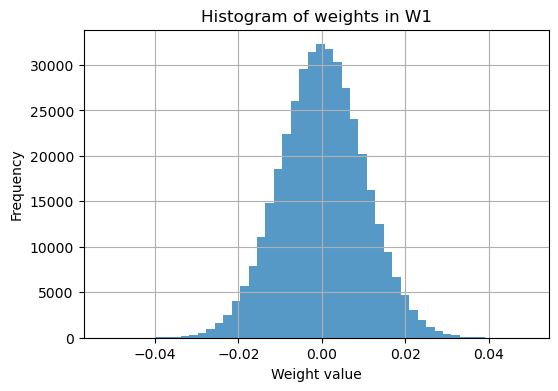

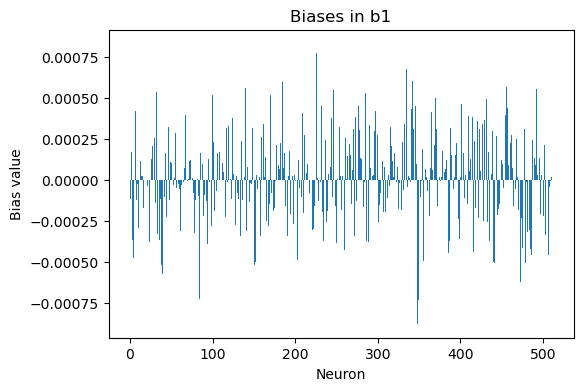

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# 参数热力图
def plot_heatmap(weights, layer_name, filename=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(weights, annot=False, cmap='coolwarm', center=0)
    plt.title(f"Heatmap for {layer_name}")
    plt.xlabel("Input Neurons")
    plt.ylabel("Output Neurons")
    if filename:
        plt.savefig(filename)  # 确保目录存在或在此处添加代码以创建目录
    plt.show()

# 权重直方图
def plot_histogram(weights, layer_name, filename=None):
    plt.figure(figsize=(6, 4))
    plt.hist(weights.flatten(), bins=50, alpha=0.75)
    plt.title(f"Histogram of weights in {layer_name}")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.grid(True)
    if filename:
        plt.savefig(filename)
    plt.show()

# 偏置项可视化
def plot_biases(biases, layer_name, filename=None):
    plt.figure(figsize=(6, 4))
    # 使用.squeeze()来确保biases是一维的
    plt.bar(range(len(biases.squeeze())), biases.squeeze())
    plt.title(f"Biases in {layer_name}")
    plt.xlabel("Neuron")
    plt.ylabel("Bias value")
    if filename:
        plt.savefig(filename)
    plt.show()


# 加载模型
model = load_model('trained_model.pkl')

# 举例调用和保存图表
plot_heatmap(model["W1"], "W1", "output/heatmap_W1.png")
plot_histogram(model["W1"], "W1", "output/histogram_W1.png")
plot_biases(model["b1"], "b1", "output/biases_b1.png")

# 确保继续为其他权重和偏置调用绘图函数


In [147]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

def plot_accuracy_curve(val_accuracies, filename=None):
    plt.figure(figsize=(8, 6))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()



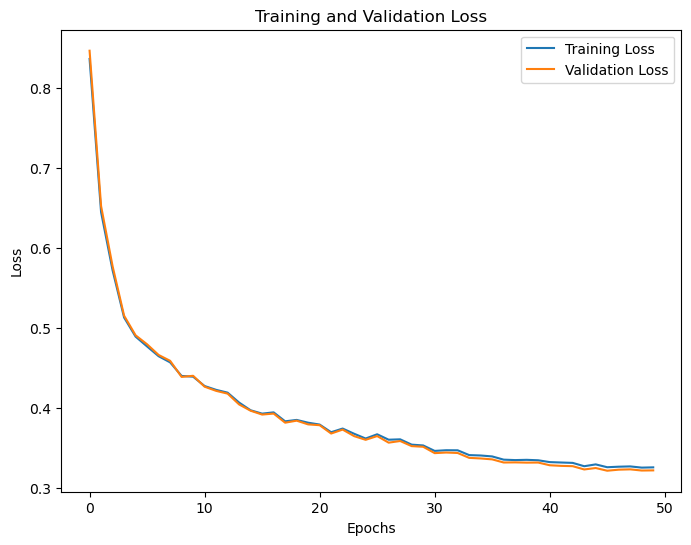

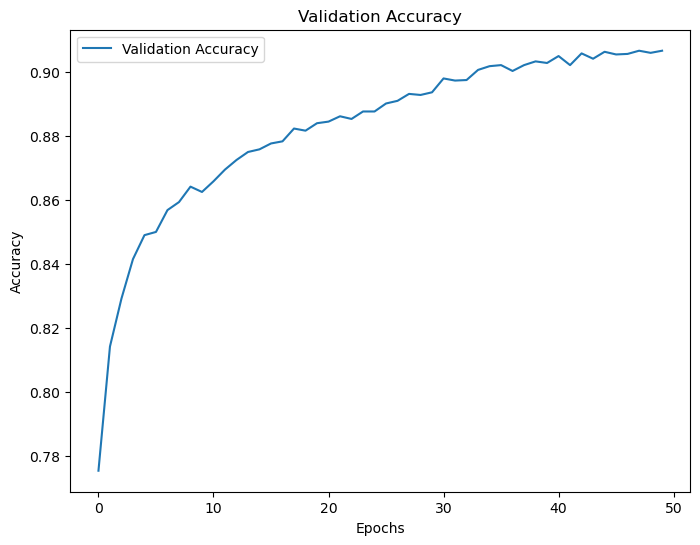

In [203]:
# 绘制损失曲线
plot_loss_curves(history_train_losses, history_val_losses, "output/training_validation_loss.png")

# 绘制准确率曲线
plot_accuracy_curve(history_val_accuracies, "output/validation_accuracy.png")


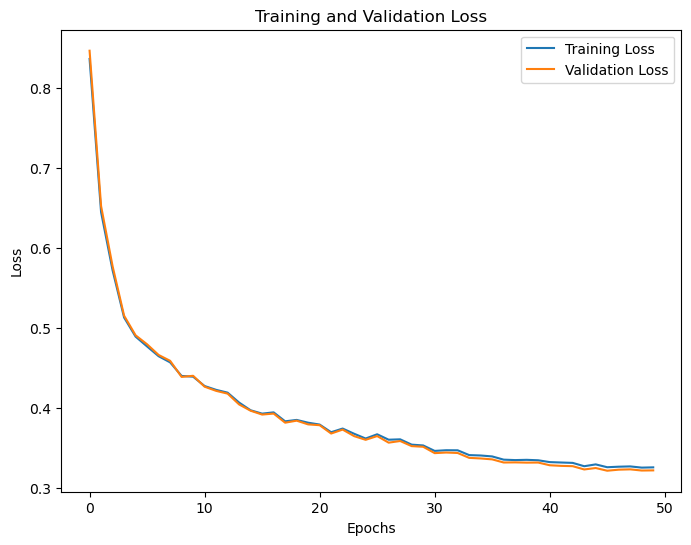

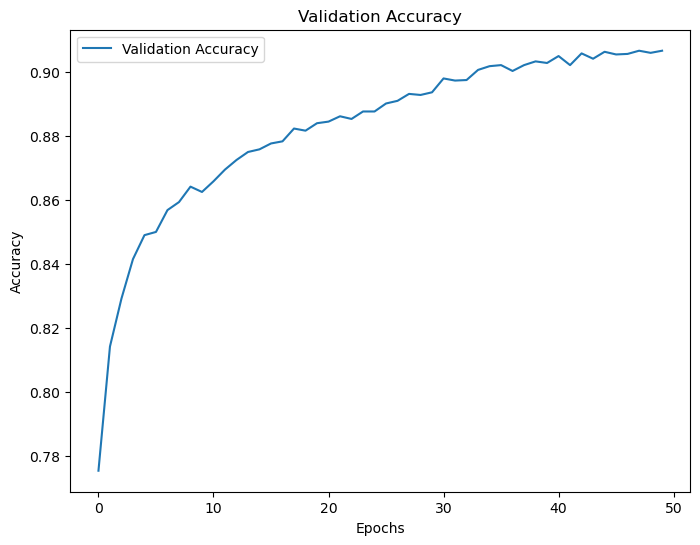

In [204]:
# 假设数据加载、模型训练等都已正确进行

# 绘制训练过程中的损失曲线和验证集上的准确率曲线
plot_loss_curves(history_train_losses, history_val_losses, "output/training_validation_loss.png")
plot_accuracy_curve(history_val_accuracies, "output/validation_accuracy.png")
